In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *
from nlputils import split_wiki,get_wiki
import os
from tqdm import tqdm

torch.cuda.set_device(1)

In [2]:
data_path = Config.data_path(); data_path

PosixPath('/home/momgpu/.fastai/data')

In [3]:
lang = 'fr'

In [4]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

In [5]:
path

PosixPath('/home/momgpu/.fastai/data/frwiki')

In [6]:
dest = split_wiki(path, lang); dest

/home/momgpu/.fastai/data/frwiki/docs already exists; not splitting


PosixPath('/home/momgpu/.fastai/data/frwiki/docs')

In [ ]:
df_TEMP = pd.read_csv(f"{path}/1sttry.csv")

In [ ]:
df_TEMP = df_TEMP.iloc[:50000, :]


In [ ]:
split_ratio = 0.1
tot_len = len(df_TEMP)
split_index = int(tot_len *(1-split_ratio))

In [ ]:
split_index

In [ ]:
df_train = df_TEMP.iloc[:split_index, :]
df_valid = df_TEMP.iloc[split_index:tot_len, :]

In [ ]:
df_train['is_valid'] = False
df_valid['is_valid'] = True

In [ ]:
df_train, df_valid

In [ ]:
df_regroup = pd.concat([df_train, df_valid])

In [ ]:
df_regroup

In [ ]:
df_regroup.to_csv(path/'50ktrain.csv', header=None, index=None)

## Section training en parallèle

In [5]:
# Dépend du GPU
bs=64

In [6]:
data = load_data(path, f'{lang}_databunch_50k', bs=bs)

In [7]:
learn2 = language_model_learner(data, AWD_LSTM, drop_mult=0.5, callback_fns=ShowGraph, pretrained=False).to_fp16()

In [8]:
lr = 1e-2
lr *= bs/48  # Scale learning rate by batch size

epoch,train_loss,valid_loss,accuracy,time
0,3.782096,3.783221,0.314423,1:14:20
1,3.782545,3.824753,0.309426,1:14:24
2,3.821367,3.821379,0.309338,1:14:18
3,3.764709,3.767718,0.314377,1:14:17
4,3.734682,3.711955,0.319402,1:14:14
5,3.669738,3.637073,0.326478,1:14:15
6,3.632734,3.542864,0.335650,1:14:21
7,3.519324,3.448922,0.345502,1:14:20
8,3.446448,3.370970,0.354389,1:14:17
9,3.418382,3.342573,0.357947,1:14:17


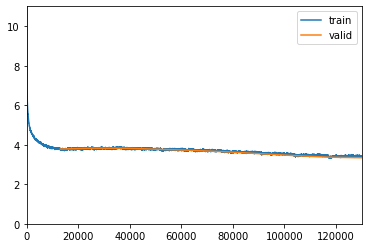

In [9]:
learn2.unfreeze()
learn2.fit_one_cycle(10, lr, moms=(0.8,0.7))

In [7]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)

In [10]:
learn2.to_fp32().save(mdl_path/"2ndweights50k_with_60kwords", with_opt=False)
learn2.data.vocab.save(mdl_path/'2ndvocab50k_with_60kwords.pkl')

In [11]:
model1 = load_learner(mdl_path, "test.pkl")

In [16]:
learn2.predict("Salut je teste le modèle pour voir s'il est cohérent.", 45, temperature=0.1)

"Salut je teste le modèle pour voir s'il est cohérent. Il est le premier film de Disney à être réalisé par Disney . Il est sorti le . Il est sorti le . Il est sorti le . Il est sorti le . Il est sorti le"

In [17]:
model1.predict("C'est le quatrième opus de la saga Star Wars par sa date de sortie, mais le premier dans l'ordre chronologique de l'histoire. Sorti seize ans après Le Retour du Jedi, il ouvre une nouvelle trilogie de préquelle, la « prélogie ». ", 1000, temperature=0.7)

'C\'est le quatrième opus de la saga Star Wars par sa date de sortie, mais le premier dans l\'ordre chronologique de l\'histoire. Sorti seize ans après Le Retour du Jedi, il ouvre une nouvelle trilogie de préquelle, la « prélogie ».  Une nouvelle série « " Dark City " » est sortie en tant que seconde « " Trilogie du Futur " » . Cette trilogie comprend le premier épisode de la série , « " Les Petites Victoires de Implantation " » , sorti en 2018 . En France , la série a été diffusée sur Cartoon Network , Canal+ , Diffusion Radio et Chaîne Disney . La série est également diffusée sur Disney Channel et Disney Channel France . En France , cette série est la première série de la série à être diffusée sur Disney Channel France . La série est diffusée depuis le sur la chaîne de télévision américaine NBC . Dans la version française , la série est diffusée en France sur France 3 France , puis dans la Belgique sur La Une . En France , la série est diffusée depuis le sur Canal+ . Au Québec , la s